In [1]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt

In [24]:
data_file = "/media/data/projects/crophisto/data.npy"
data = np.load(data_file)
y = data[:, 11]
X = data[:, :11]

X.shape



(1984471, 11)

In [46]:
np.unique(X[:,2]).shape


(9,)

In [16]:
sample_size = 15000
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=0)

In [25]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [26]:
print(X_test.shape)
print(y_test.shape)

100/29

(15000, 11)
(15000,)


3.4482758620689653

In [13]:
np.unique(data)

array([-32768, -32767, -32766, ...,  32765,  32766,  32767], dtype=int16)

Mean support: 556, mean_frequency: 3.70%
Min support: 1000, min_frequency: 1.11%
[3143  284  356 2335  634    9 2393  920   27   64   83  324  241    5
   37  192   52   24    4   65   20 1955  726   86  457  564]
[  1   3   4   5   8   9  20  33  35  39  40  60  61  80  82 100 101 110
 177 181 183 200 201 202 203 204 255]


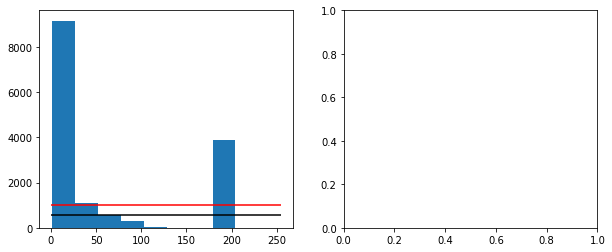

In [30]:
# find categories with less that min_size
num_categories = len(np.unique(y_test))
mean_frequency = (100/num_categories)/100 # porc
mean_support = round(sample_size * mean_frequency)
# min_frequency = mean_frequency * 0.15
min_frequency = mean_frequency * 0.30
min_support = 1000 #round(sample_size * min_frequency)
round(min_support)
print("Mean support: {}, mean_frequency: {:.2%}".format(mean_support, mean_frequency))
print("Min support: {}, min_frequency: {:.2%}".format(min_support, min_frequency))

# find categories under represented
categories = np.sort(np.unique(y_test))
freq, bins = np.histogram(y_test, bins=categories)

print (freq)
print(bins)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(y_test,)
axs[0].hlines(mean_support,0,max(y_test))
axs[0].hlines(min_support,0,max(y_test), colors="r")
# axs[1].hist(X_test.flatten())


In [31]:
under_categories = (freq<min_support).nonzero()[0]

under_categories
print(freq)
print(min_support)

[3143  284  356 2335  634    9 2393  920   27   64   83  324  241    5
   37  192   52   24    4   65   20 1955  726   86  457  564]
1000


In [35]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print(categories)

print("needed: \n{}".format(needed))


[  1   3   4   5   8   9  20  33  35  39  40  60  61  80  82 100 101 110
 177 181 183 200 201 202 203 204 255]
needed: 
[  0 716 644   0 366 991   0  80 973 936 917 676 759 995 963 808 948 976
 996 935 980   0 274 914 543 436]


(15000, 11)

In [36]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print("Initial dataset shape: {} ".format(X.shape))
y = y_test.copy()
X = X_test.copy()

data_copy = data[:, 3:11]

for index, needed_for_category in enumerate(needed):
    if needed_for_category == 0:
        continue
    category_code = categories[index]
    
    print("Adding {} samples for category {}".format(needed_for_category, category_code))
    # filter data for this category
    cat_mask = (y_train == category_code)
    
    # define the lower bound as the limit of samples to get from this category
    bound = min(needed_for_category, len(cat_mask == True))
    cat_y = y_train[cat_mask][:bound]
    y = np.hstack([y,cat_y])

    cat_X = X_train[cat_mask,:][:bound,:]
    X = np.vstack([X,cat_X])

dataset = np.hstack([X, y.reshape(-1,1)])

print("Final dataset shape: {}".format(dataset.shape))




Initial dataset shape: (1984471, 11) 
Adding 716 samples for category 3
Adding 644 samples for category 4
Adding 366 samples for category 8
Adding 991 samples for category 9
Adding 80 samples for category 33
Adding 973 samples for category 35
Adding 936 samples for category 39
Adding 917 samples for category 40
Adding 676 samples for category 60
Adding 759 samples for category 61
Adding 995 samples for category 80
Adding 963 samples for category 82
Adding 808 samples for category 100
Adding 948 samples for category 101
Adding 976 samples for category 110
Adding 996 samples for category 177
Adding 935 samples for category 181
Adding 980 samples for category 183
Adding 274 samples for category 201
Adding 914 samples for category 202
Adding 543 samples for category 203
Adding 436 samples for category 204
Final dataset shape: (31015, 12)


[3143 1000 1000 2335 1000 1000 2393 1000 1000 1000 1000 1000 1000  628
 1000 1000 1000 1000  561 1000 1000 1955 1000 1000 1000 1000]
[  1   3   4   5   8   9  20  33  35  39  40  60  61  80  82 100 101 110
 177 181 183 200 201 202 203 204 255]


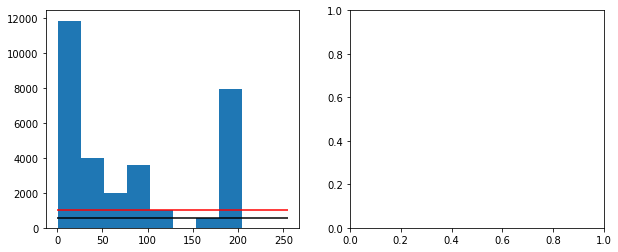

In [37]:
freq, bins = np.histogram(y, bins=categories)

print (freq)
print(bins)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(y)
axs[0].hlines(mean_support,0,max(y))
axs[0].hlines(min_support,0,max(y), colors="r")
# axs[1].hist(X.flatten())


In [38]:
#save the data
np.save("../resources/data_sampled", dataset)

### one hot encoding dataset


In [13]:
from keras.utils import to_categorical

vocab_size = len(np.unique(data))
print("vocab_size: {}".format(vocab_size))

def f_to_categorical(x):
    return to_categorical(x, num_classes=vocab_size)


X_prim = np.zeros(X.shape[0], X.shape[1]*vocab_size)
for i in X.shape[1]:
    col = X[:,i]
    col_prim = to_categorical(x, num_classes=vocab_size)
    X_prim[:,i:i+vocab_size]
    

print("original X size: {}".format(X.shape))
X_prim = np.apply_along_axis(f_to_categorical, 0, X)
print("transformed X size: {}".format(X_prim.shape))

r =to_categorical(X[:,1],num_classes=28)



vocab_size: 27


TypeError: data type not understood

### undersampled dataset

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(y)
axs[0].hlines(mean_support,0,27)
axs[0].hlines(min_support,0,27, colors="r")
axs[1].hist(X.flatten())
axs[2].hist(X_test.flatten())


In [ ]:
# Create undersampling data set

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

y = data[:, 8]
X = data[:, 0:8]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(y_resampled,)
axs[0].hlines(mean_support,0,27)
axs[0].hlines(min_support,0,27, colors="r")
axs[1].hist(X.flatten())
axs[2].hist(X_resampled.flatten())

print(y.shape)
print(y_resampled.shape)


dataset = np.hstack([X_resampled, y_resampled.reshape(-1,1)])

print("Final dataset shape: {}".format(dataset.shape))

np.save("../resources/data_undersampled", dataset)
